In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

### : Utility

In [2]:
def getFileName(filePath):
    return filePath.split('\\')[-1]

In [3]:
def importDataInfo(path):
    columns = ['Center','Left','Right','Steering','Throttle','Brake','Speed']
    data = pd.read_csv(os.path.join(path,'driving_log.csv'),names = columns)
#     print(data.head())
#     print(data['Center'][0])
#     print(getFileName(data['Center'][0]))
    data['Center'] = data['Center'].apply(getFileName)
#     print(data.head())
    print('Total images imported : ',data.shape[0])
    return data

In [4]:
def balanceData(data,display=1):
    nBins = 31
    samplePerBin = 300
    hist, bins = np.histogram(data['Steering'],nBins)
    print(bins)
    if display:
        center = (bins[:-1]+bins[1:])*0.5
#         print(center)
        plt.bar(center,hist,width=0.06)
        plt.plot((-1,1),(samplePerBin,samplePerBin))
        plt.show()
        
    removeIndexList = [ ]
    for j in range(nBins):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j+1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplePerBin:]
        removeIndexList.extend(binDataList)
    print('Removed Images : ', len(removeIndexList))
    data.drop(data.index[removeIndexList],inplace = True)
    print('Remaining Images : ',len(data))
    
    if display:
        hist, _ = np.histogram(data['Steering'],nBins)
        plt.bar(center,hist,width=0.06)
        plt.plot((-1,1),(samplePerBin,samplePerBin))
        plt.show()
        
    return data

In [5]:
def loadData(path,data):
    imagesPath = []
    steering = []
    
    for i in range(len(data)):
        indexedData = data.iloc[i]
#         print(indexedData)
        imagesPath.append(os.path.join(path,'IMG',indexedData[0]))
#         print(os.path.join(path,'IMG',indexedData[0]))
        steering.append(float(indexedData[3]))
    
    imagesPath =np.asarray(imagesPath)
    steering = np.asarray(steering)
    return imagesPath, steering

In [6]:
def augmentImage(imgPath, steering):
    img = mpimg.imread(imgPath)
    ###PAN
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={'x':(-0.1,0.1),'y':(-0.1,0.1)})
        img = pan.augment_image(img)
    ###ZOOM
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1,1.2))
        img = zoom.augment_image(img)
    ###BRIGHTNESS
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.4,1.2))
        img = brightness.augment_image(img)
    ###FLIP
    if np.random.rand() < 0.5:
        img = cv2.flip(img,1)
        steering = -steering
    
    return img, steering

In [7]:
def preProcessing(img):
    img = img[60:135,:,:] ## only cropping the height
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3),0)
    img = cv2.resize(img,(200,66))
    img = img/255
    return img

In [8]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    while 1:
        imgBatch = []
        steeringBatch = []
        
        for i in range(batchSize):
            index = random.randint(0,len(imagesPath)-1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcessing(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield(np.asarray(imgBatch),np.asarray(steeringBatch))

In [9]:
def createModel():
    model = Sequential()
    
    model.add(Convolution2D(24,(5,5),(2,2), input_shape = (66,200,3), activation = 'elu'))
    model.add(Convolution2D(36,(5,5),(2,2), activation = 'elu'))
    model.add(Convolution2D(48,(5,5),(2,2), activation = 'elu'))
    model.add(Convolution2D(64,(3,3), activation = 'elu'))
    model.add(Convolution2D(64,(3,3), activation = 'elu'))
    
    model.add(Flatten())
    model.add(Dense(100,activation='elu'))
    model.add(Dense(50,activation='elu'))
    model.add(Dense(10,activation='elu'))
    model.add(Dense(1))
    
    model.compile(Adam(lr=0.0001),loss='mse') ### mse bcz it's a regression problem
    
    return model

### : Main

In [10]:
### step 1
path = 'myData'
data = importDataInfo(path)

Total images imported :  5254


[-1.         -0.93548387 -0.87096774 -0.80645161 -0.74193548 -0.67741935
 -0.61290323 -0.5483871  -0.48387097 -0.41935484 -0.35483871 -0.29032258
 -0.22580645 -0.16129032 -0.09677419 -0.03225806  0.03225806  0.09677419
  0.16129032  0.22580645  0.29032258  0.35483871  0.41935484  0.48387097
  0.5483871   0.61290323  0.67741935  0.74193548  0.80645161  0.87096774
  0.93548387  1.        ]


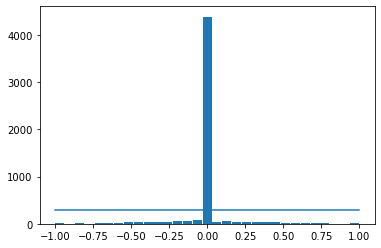

Removed Images :  4092
Remaining Images :  1162


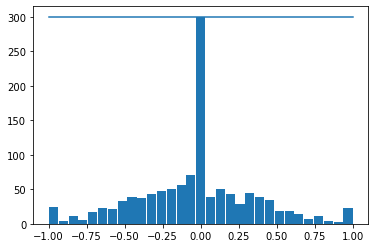

                                  Center  \
25    center_2022_01_01_11_47_09_326.jpg   
26    center_2022_01_01_11_47_09_400.jpg   
27    center_2022_01_01_11_47_09_475.jpg   
28    center_2022_01_01_11_47_09_552.jpg   
34    center_2022_01_01_11_47_09_985.jpg   
...                                  ...   
5223  center_2022_01_01_11_58_17_000.jpg   
5235  center_2022_01_01_11_58_17_850.jpg   
5236  center_2022_01_01_11_58_17_933.jpg   
5239  center_2022_01_01_11_58_18_141.jpg   
5243  center_2022_01_01_11_58_18_433.jpg   

                                                   Left  \
25    D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   
26    D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   
27    D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   
28    D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   
34    D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   
...                                                 ...   
5223  D:\New folder\CODE\PYTHON\AI_ML_DL_python\Comp...   

In [11]:
### step 2
data = balanceData(data,display=1)
print(data)

In [12]:
### step 3
imagesPath, steering = loadData(path,data)
print(imagesPath[0],'\n',steering[0])

myData\IMG\center_2022_01_01_11_47_09_326.jpg 
 -0.1545064


In [13]:
### step 4
x_train, x_val, y_train, y_val = tts(imagesPath, steering, test_size = 0.2, random_state=5)
print('Total Training Images : ', len(x_train))
print('Total Validation Images : ', len(x_val))

Total Training Images :  929
Total Validation Images :  233


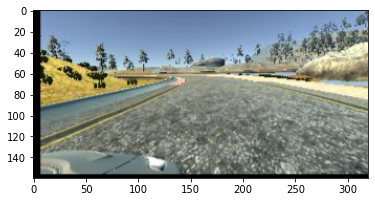

In [14]:
### step 5
imgRe, st = augmentImage(os.path.join(path,'test.jpg'),0)
plt.imshow(imgRe)
plt.show()

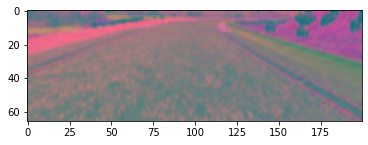

In [15]:
### step 6
imgRe2 = preProcessing(mpimg.imread(os.path.join(path,'test.jpg')))
plt.imshow(imgRe2)
plt.show()

In [16]:
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

C:\Users\LOKESH\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(batchGen(x_train,y_train,100,1), steps_per_epoch=300, epochs=10, 
          validation_data = batchGen(x_val,y_val, 100,0),validation_steps=200)

In [48]:
model.save('model.h5')
print('Model Saved')

Model Saved


<ipython-input-52-78efaed25962>:3: UserWarning: Legend does not support 'Training' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(['Training'],['Validation'])


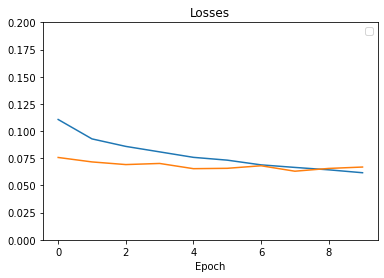

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training'],['Validation'])
plt.title('Losses')
plt.ylim([0,0.2])
plt.xlabel('Epoch')
plt.show()